#Dependencies

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Nadam, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.models import Model

import random
import tensorflow as tf
import cv2
import os
import time

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score


#Classes and Functions used

##Functions

In [2]:
def display_img(image,title='Image',x_label=None,y_label=None,cmap_type='gray',show_axis=False,colorBar=False,F_size=(8,6)):
  plt.figure(figsize=F_size)
  plt.imshow(image,cmap=cmap_type)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  if colorBar: plt.colorbar()
  if not show_axis: plt.axis('off')
  plt.show()

def show_graphs(curve1,curve2,title,xlabel,ylabel):

  plt.plot(curve1)
  plt.plot(curve2)
  plt.title(f'Model {title}')
  plt.ylabel(xlabel)
  plt.xlabel(ylabel)
  plt.legend(['train', 'validation'])
  plt.show()

#Loading the dataset

In [25]:
#select_images_randomly = False

#Get images from google drive
directory_path_malignos = '/content/drive/MyDrive/BootcampFinal/cropped_and_treated_100_nods_benigno/'
directory_path_benignos = '/content/drive/MyDrive/BootcampFinal/cropped_and_treated_100_nods_maligno/'

directory_files = os.listdir(directory_path_malignos)
array_of_images_malignos = [plt.imread( os.path.join(directory_path_malignos,file),format='.png' ) for file in directory_files]

directory_files = os.listdir(directory_path_benignos)
array_of_images_benignos = [plt.imread( os.path.join(directory_path_benignos,file),format='.png' ) for file in directory_files]

array_of_images_malignos.pop(0)

print(f'Number of cropped maligno images: {len(array_of_images_malignos)}')
print(f'Number of cropped benigno images: {len(array_of_images_benignos)}')


Number of cropped maligno images: 275
Number of cropped benigno images: 262


##Data augmentation

Only execute the first cell below after cleaning up the folder that will store the new images. Otherwise, it will merge the new dataset with the previous one. To prevent that misuse, I commented out the folder path.

In [ ]:
batch_size = 2
loop_number = 30

array_of_images_malignos_tf = tf.expand_dims(array_of_images_malignos,axis=-1)
array_of_images_benignos_tf = tf.expand_dims(array_of_images_benignos,axis=-1)

datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 45, 
        width_shift_range=0.2,  # horizontal shift
        height_shift_range=0.2,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True)

datagen.fit(array_of_images_malignos_tf)

count = 0

new_images_malignos_y,new_images_benignos_y = [],[]

#save_to_dir="/content/drive/MyDrive/BootcampFinal/generated_malignos_img/"
for batch in datagen.flow(array_of_images_malignos_tf, batch_size=batch_size, save_format='png'):
    count += 1
    for index in range(batch_size):    
      new_images_malignos_y.append(1)
    if count >= loop_number:
        break

datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 40, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True)

datagen.fit(array_of_images_benignos_tf)

count = 0

new_images_x,new_images_y = [],[]

#save_to_dir="/content/drive/MyDrive/BootcampFinal/generated_benignos_img/"
for batch in datagen.flow(array_of_images_benignos_tf, batch_size=batch_size, save_format='png'):
    count += 1
    for index in range(batch_size):    
      new_images_benignos_y.append(0)
    if count >= loop_number:
        break



In [ ]:
generated_malignos_img = "/content/drive/MyDrive/BootcampFinal/generated_malignos_img/"
generated_benignos_img = "/content/drive/MyDrive/BootcampFinal/generated_benignos_img/"

directory_files = os.listdir(generated_malignos_img)
new_images_malignos = [plt.imread( os.path.join(generated_malignos_img,file) ) for file in directory_files]

directory_files = os.listdir(generated_benignos_img)
new_images_benignos = [plt.imread( os.path.join(generated_benignos_img,file) ) for file in directory_files]

print(f'Number of cropped maligno images: {len(new_images_malignos)}')
print(f'Number of cropped benigno images: {len(new_images_benignos)}')

Number of cropped maligno images: 60
Number of cropped benigno images: 60


#Spliting the dataset into training and test set.

In [26]:
use_augmentation = False

if use_augmentation:
  x = np.array([*array_of_images_malignos,*array_of_images_benignos,*new_images_malignos,*new_images_benignos])
  y = np.array([*[1 for _ in array_of_images_malignos],*[0 for _ in array_of_images_benignos],*[1 for _ in new_images_malignos],*[0 for _ in new_images_benignos]])
else:
  x = np.array([*array_of_images_malignos,*array_of_images_benignos])
  y = np.array([*[1 for _ in array_of_images_malignos],*[0 for _ in array_of_images_benignos]])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True)
x_test_tranformed = np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in x_test]) 

x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
x_test_tranformed = tf.expand_dims(x_test_tranformed, axis=-1)

print(f'Size of training set {len(y_train)}')
unique, counts = np.unique(y_train, return_counts=True)
count_result= dict(zip(unique, counts))
print(f'class 0 size: {count_result[0]} class 1 size: {count_result[1]}. ratio: {count_result[1]/(count_result[0]+count_result[1])}')

print(f'Size of test set {len(y_test)}')
unique, counts = np.unique(y_test, return_counts=True)
count_result= dict(zip(unique, counts))
print(f'class 0 size: {count_result[0]} class 1 size: {count_result[1]}. ratio: {count_result[1]/(count_result[0]+count_result[1])}')

x_train = np.array([*x_train,])
y_train = np.array([*y_train,])

Size of training set 429
class 0 size: 212 class 1 size: 217. ratio: 0.5058275058275058
Size of test set 108
class 0 size: 50 class 1 size: 58. ratio: 0.5370370370370371


#Building the model and perfoming the simulations


##Performing simulations

About All layers provided by Keras: https://keras.io/api/layers/

###Setting up the architectures

In [34]:
architectures = {
    'simulation1':{
      'layers':{
          'layer_1':{
              'type':'conv2',
              'parameters':{'filters':16,'kernel_size':9,'padding':'same','activation':'relu','input_shape': (98,98,1)}
          },
          'layer_2':{
              'type':'maxPooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_3':{
              'type':'conv2',
              'parameters':{'filters':32,'kernel_size':5,'padding':'same','activation':'relu'}
          },
          'layer_4':{
              'type':'maxPooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_5':{
              'type':'conv2',
              'parameters':{'filters':64,'kernel_size':3,'padding':'same','activation':'relu'}
          },
          'layer_6':{
              'type':'maxPooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_7':{
              'type':'flatten',
              'parameters':None
          },
          'layer_8':{
              'type':'dense',
              'parameters':{'units':15,'activation':'relu'}
          },
          'layer_9':{
              'type':'dense',
              'parameters':{'units':10,'activation':'relu'}
          },
          'layer_10':{
              'type':'dense',
              'parameters':{'units':2,'activation':'softmax'}
          }
       },
      'compile':{'loss':'sparse_categorical_crossentropy','metrics':['accuracy']},
      'fit':{'epochs':150,'initial_epoch':0,'validation_split':0.3}
    },
    'simulation2':{
      'layers':{
          'layer_1':{
              'type':'conv2',
              'parameters':{'filters':16,'kernel_size':9,'padding':'same','activation':'relu','input_shape': (98,98,1)}
          },
          'layer_2':{
              'type':'maxPooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          }
         ,
          'layer_3':{
              'type':'conv2',
              'parameters':{'filters':32,'kernel_size':5,'padding':'same','activation':'relu'}
          },
          'layer_4':{
              'type':'maxPooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_5':{
              'type':'flatten',
              'parameters':None
          },
          'layer_6':{
              'type':'dense',
              'parameters':{'units':15,'activation':'relu'}
          },
          'layer_7':{
              'type':'dense',
              'parameters':{'units':10,'activation':'relu'}
          },
          'layer_8':{
              'type':'dense',
              'parameters':{'units':2,'activation':'softmax'}
          }
       },
      'compile':{'loss':'sparse_categorical_crossentropy','metrics':['accuracy']},
      'fit':{'epochs':150,'initial_epoch':0,'validation_split':0.3}
    },
    'simulation3':{
      'layers':{
          'layer_1':{
              'type':'conv2',
              'parameters':{'filters':64,'kernel_size':9,'padding':'same','activation':'relu','input_shape': (98,98,1)}
          },
          'layer_2':{
              'type':'AveragePooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_3':{
              'type':'conv2',
              'parameters':{'filters':48,'kernel_size':5,'padding':'same','activation':'relu'}
          },
          'layer_4':{
              'type':'maxPooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_5':{
              'type':'conv2',
              'parameters':{'filters':32,'kernel_size':3,'padding':'same','activation':'relu'}
          },
          'layer_6':{
              'type':'AveragePooling',
              'parameters':{'pool_size':[2,2],'strides':2}
          },
          'layer_7':{
              'type':'flatten',
              'parameters':None
          },
          'layer_8':{
              'type':'dense',
              'parameters':{'units':25,'activation':'relu'}
          },
          'layer_9':{
              'type':'dense',
              'parameters':{'units':15,'activation':'relu'}
          },
          'layer_10':{
              'type':'dense',
              'parameters':{'units':10,'activation':'relu'}
          },
          'layer_11':{
              'type':'dense',
              'parameters':{'units':2,'activation':'softmax'}
          }
       },
      'compile':{'loss':'sparse_categorical_crossentropy','metrics':['accuracy']},
      'fit':{'epochs':150,'initial_epoch':0,'validation_split':0.3}
    }
}

###Simulations



Performing the simulation1:


loop: 0:


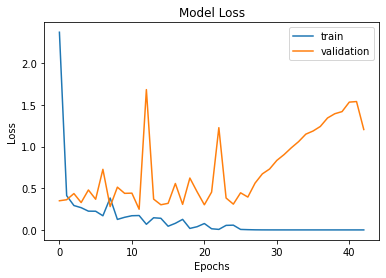

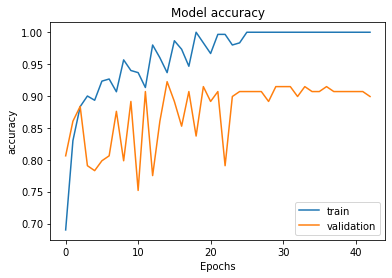

4/4 [==============================] - 1s 134ms/step
{'accuracy': [0.8611111111111112], 'recall': [0.9137931034482759], 'precision': [0.8412698412698413], 'time_used_to_train': [279.5538191795349]}


Performing the simulation2:


loop: 0:


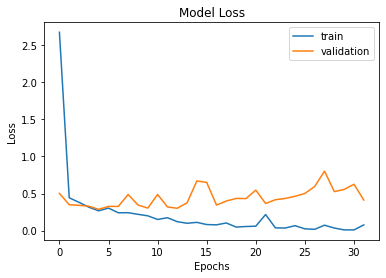

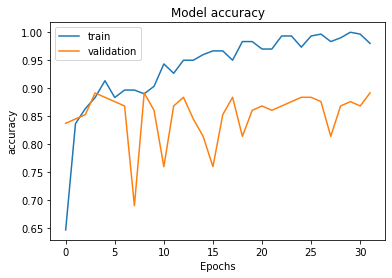

4/4 [==============================] - 1s 124ms/step
{'accuracy': [0.8518518518518519], 'recall': [0.8275862068965517], 'precision': [0.8888888888888888], 'time_used_to_train': [192.59048700332642]}


Performing the simulation3:


loop: 0:


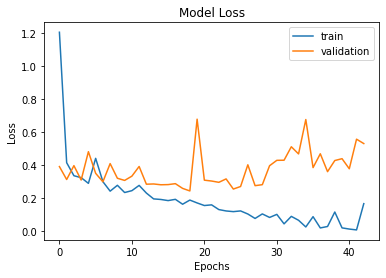

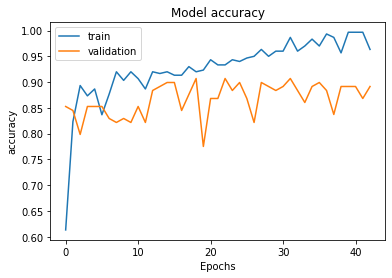

4/4 [==============================] - 1s 311ms/step
{'accuracy': [0.8888888888888888], 'recall': [0.8620689655172413], 'precision': [0.9259259259259259], 'time_used_to_train': [734.2830891609192]}


In [35]:
qtd_simulations = 1

results = {key:{'accuracy':[],'recall':[],'precision':[],'time_used_to_train':[]} for key in architectures.keys()}

for key in architectures:
  
  print(f'\n\nPerforming the {key}:\n\n')

  for index in range(qtd_simulations):

    print(f'loop: {index}:')
    model = keras.Sequential()

    for layer_number in architectures[key]['layers']:

      if architectures[key]['layers'][layer_number]['type'] == 'conv2':
        model.add(keras.layers.Conv2D( **architectures[key]['layers'][layer_number]['parameters'] ))
        continue

      if architectures[key]['layers'][layer_number]['type'] == 'maxPooling':
        model.add(keras.layers.MaxPooling2D(**architectures[key]['layers'][layer_number]['parameters']))
        continue
      
      if architectures[key]['layers'][layer_number]['type'] == 'AveragePooling':
        model.add(keras.layers.AveragePooling2D(**architectures[key]['layers'][layer_number]['parameters']))
        continue

      if architectures[key]['layers'][layer_number]['type'] == 'BatchNormalization':
        model.add(keras.layers.BatchNormalization())
        continue

      if architectures[key]['layers'][layer_number]['type'] == 'flatten':
        model.add(keras.layers.Flatten())
        continue

      if architectures[key]['layers'][layer_number]['type'] == 'dense':
        model.add(Dense(**architectures[key]['layers'][layer_number]['parameters']))
        continue
      
      print('Samething went wrong')
    
    #model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience=28,restore_best_weights=False) 
    start = time.time()
    model.compile(**architectures[key]['compile'])
    history = model.fit(x_train,y_train,**architectures[key]['fit'],verbose=0,callbacks=[callback])
    end = time.time()

    show_graphs(history.history['loss'],history.history['val_loss'],'Loss','Loss','Epochs')
    show_graphs(history.history['accuracy'],history.history['val_accuracy'],'accuracy','accuracy','Epochs')

    result = model.evaluate(x_test,y_test)
    time_used = end-start
    
    prediction_result = model.predict(x_test)
    prediction_result_tranformed = [0 if number[0]>number[1] else 1 for number in prediction_result]

    accuracy = accuracy_score(y_test,prediction_result_tranformed)
    recall = recall_score(y_test,prediction_result_tranformed)
    precision = precision_score(y_test,prediction_result_tranformed)

    results[key]['accuracy'].append(accuracy)
    results[key]['recall'].append(recall)
    results[key]['precision'].append(precision)

    results[key]['time_used_to_train'].append(time_used)
    
    print(results[key])


In [ ]:
results.keys()

agrouped_result = dict()

for simulation in results.keys():

  agrouped_result[simulation] = dict()

  for metric in results[simulation].keys():
    
    agrouped_result[simulation][metric] = dict()
    agrouped_result[simulation][metric]['mean'] = np.mean(results[simulation][metric])
    agrouped_result[simulation][metric]['std'] = np.std(results[simulation][metric])

print(agrouped_result)

In [ ]:
display(agrouped_result)

### VGG

In [ ]:
vgg16_architectures = {
    'simulation1':{
        'layer_1':{
            'units':1024,
            'activation':'relu'
        },
        'layer_2':{
            'units':512,
            'activation':'relu'
        },
        'layer_3':{
            'units':30,
            'activation':'relu'
        }
    },
    'simulation2':{
        'layer_1':{
            'units':512,
            'activation':'relu'
        },
        'layer_2':{
            'units':256,
            'activation':'relu'
        },
        'layer_3':{
            'units':30,
            'activation':'relu'
        }
    },
    'simulation3':{
        'layer_1':{
            'units':1024,
            'activation':'relu'
        },
        'layer_3':{
            'units':30,
            'activation':'relu'
        }
    },
    'simulation4':{
        'layer_1':{
            'units':340,
            'activation':'relu'
        },
        'layer_2':{
            'units':150,
            'activation':'relu'
        },
        'layer_3':{
            'units':30,
            'activation':'relu'
        }
    },
    'simulation5':{
        'layer_1':{
            'units':300,
            'activation':'relu'
        },
        'layer_2':{
            'units':100,
            'activation':'relu'
        },
        'layer_3':{
            'units':10,
            'activation':'relu'
        }
    }
}

vgg16_result = {simulation_number:{'results':{'accuracy':[],'recall':[],'precision':[]},'time_used_to_evaluate':[]} for simulation_number in vgg16_architectures.keys()}
qtd_simulations = 5

for simulation_number in vgg16_architectures:

  for index in range(qtd_simulations):

    vgg = VGG16(input_shape=(44, 44, 3), include_top = False, weights= 'imagenet')
    x = vgg.output
    x = Flatten()(x)

    for layer in vgg16_architectures[simulation_number]:

      x = Dense(**vgg16_architectures[simulation_number][layer])(x) 
      #x = Dropout(0.5)(x)
      out = Dense(2,activation='softmax')(x)
      tf_model=Model(inputs=vgg.input,outputs=out)

      for layer in tf_model.layers[:20]:
          layer.trainable=False

    #tf_model.summary()

    adam = Adam()
    tf_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])


    #checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
    #                               verbose=2, save_best_only=True)

    result = tf_model.evaluate(x_test_tranformed,y_test)
    #time_used = end-start
      
    prediction_result = tf_model.predict(x_test_tranformed)
    prediction_result_tranformed = [0 if number[0]>number[1] else 1 for number in prediction_result]

    accuracy = accuracy_score(prediction_result_tranformed,y_test)
    recall = recall_score(prediction_result_tranformed,y_test)
    precision = precision_score(prediction_result_tranformed,y_test)
    
    vgg16_result[simulation_number]['results']['accuracy'].append(accuracy)
    vgg16_result[simulation_number]['results']['recall'].append(recall)
    vgg16_result[simulation_number]['results']['precision'].append(precision)

    print(result,accuracy,recall,precision)